In [1]:
from google.colab import drive
from google.colab import files

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.utils import get_file
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import Augmentor
import glob
import shutil

import keras_tuner as kt


In [2]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(20)

  plt.figure(figsize=(20,7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


def display_matrix(y_pred, test_labels):
  y_true = np.argmax(test_labels, axis=1)  # Convert true labels from one-hot to class indices
  y_pred = np.argmax(y_pred, axis=1)       # Convert predicted labels from one-hot to class indices

  # Now compute the confusion matrix
  confusion = confusion_matrix(y_true, y_pred)
  ConfusionMatrixDisplay(confusion, display_labels=class_names).plot()
  plt.xticks(rotation=90)
  plt.show()


def tune_params(aug_model):
  tuner = kt.RandomSearch(aug_model, objective='accuracy', seed=123, max_trials=5)
  tuner.search(train_images, train_labels, epochs=20)
  best_params = tuner.get_best_hyperparameters()[0]
  return best_params

In [84]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Test")

In [19]:
paths = []
labels = []

def create_dataset(df_path):
    for flower in os.listdir(df_path):
        path_data = os.listdir(os.path.join(df_path, flower))
        cur_path = os.path.join(df_path, flower)
        paths.extend([os.path.join(cur_path, img) for img in path_data])
        labels.extend([flower]*len(path_data))
    return pd.DataFrame({"Path":paths, "Label":labels})

In [77]:
batch_size = 32
img_height = 180
img_width = 180

In [85]:
core_train_df, core_val_df = image_dataset_from_directory(data_dir_train, image_size=(img_height, img_width), shuffle=True, seed = 123, subset="both", labels='inferred', label_mode ='int', validation_split=0.3, batch_size=batch_size, color_mode = 'rgb')
core_test_df = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), shuffle=True, seed = 123, subset=None, labels='inferred', label_mode = 'int', validation_split=None, batch_size=batch_size, color_mode = 'rgb')

Found 2239 files belonging to 9 classes.
Using 1568 files for training.
Using 671 files for validation.
Found 118 files belonging to 9 classes.


In [86]:
class_names = core_train_df.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

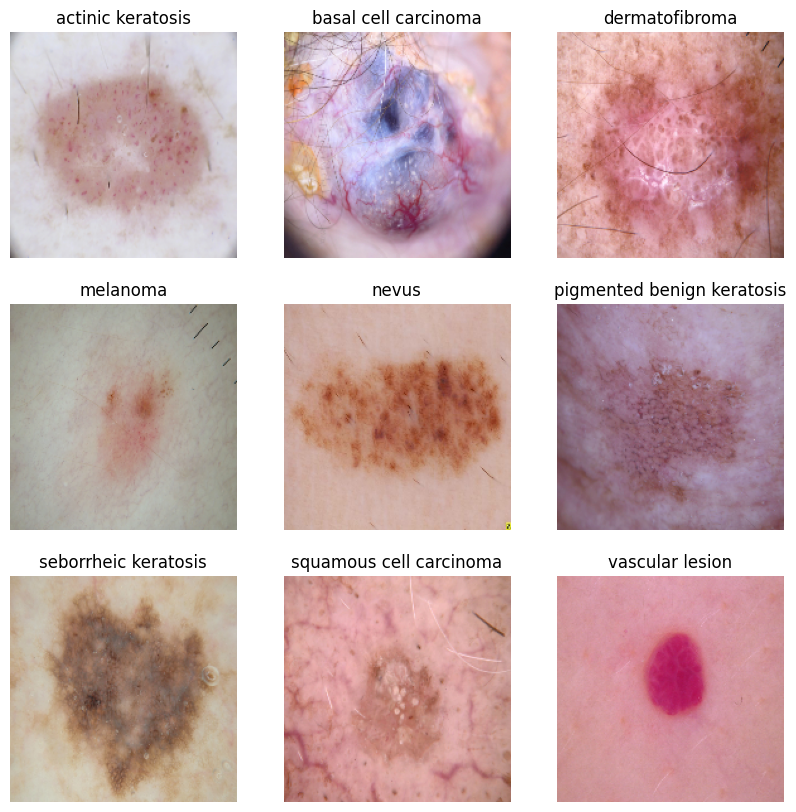

In [ ]:
## Display the images of different types ( one per class name )
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = core_train_df.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
core_train_df = core_train_df.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
core_val_df = core_val_df.cache().prefetch(buffer_size=AUTOTUNE)
core_test_df = core_test_df.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
train_df = core_train_df.map(lambda images, labels: (images, tf.one_hot(labels, len(class_names))))
val_df = core_val_df.map(lambda images, labels: (images, tf.one_hot(labels, len(class_names))))
test_df = core_test_df.map(lambda images, labels: (images, tf.one_hot(labels, len(class_names))))

In [25]:
def split_data(df):
  imgs = []
  labels = []
  for image_batch, label_batch in df:
    imgs.append(image_batch)
    labels.append(label_batch)
  imgs = tf.concat(imgs, axis = 0)
  labels = tf.concat(labels, axis = 0)
  return imgs, labels

In [40]:
train_images, train_labels = split_data(train_df)

In [41]:
val_images, val_labels = split_data(val_df)

In [42]:
test_images, test_labels = split_data(test_df)

In [36]:
## Data rescaling
data_rescaling = tf.keras.Sequential([
    layers.Rescaling(1./255)
])

In [48]:

def base_model():
  model = Sequential()
  model.add(keras.layers.Input(shape=(img_height, img_width, 3), batch_size=batch_size)),

  data_rescaling,

  model.add(keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), data_format="channels_last", activation=None)),
  model.add(keras.layers.Activation('relu')),
  model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), data_format="channels_last", activation=None)),
  model.add(keras.layers.Activation('relu')),
  model.add(MaxPooling2D(pool_size=(2,2))),
  model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', data_format="channels_last", activation=None)),
  model.add(keras.layers.Activation('relu')),
  model.add(keras.layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', data_format="channels_last", activation=None)),
  model.add(keras.layers.Activation('relu')),
  model.add(MaxPooling2D(pool_size=(2,2))),
  model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', data_format="channels_last", activation=None)),
  model.add(keras.layers.Activation('relu')),
  model.add(keras.layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), data_format="channels_last", activation=None)),
  model.add(keras.layers.Activation('relu')),
  model.add(MaxPooling2D(pool_size=(2,2))),
  model.add(keras.layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', data_format="channels_last", activation=None)),
  model.add(keras.layers.Activation('relu')),

  model.add(keras.layers.Flatten()),
  model.add(keras.layers.Dense(256, activation='relu')),
  model.add(keras.layers.Dense(256, activation='relu')),
  model.add(keras.layers.Dense(len(class_names), activation='softmax'))

  ## Compile the model
  model.compile(optimizer='adam',
                loss = 'categorical_crossentropy',
                metrics=['accuracy',
                        "f1_score",
                        "precision",
                        "recall"])

  return model

In [49]:
base_model = base_model()
base_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (32, 178, 178, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (32, 178, 178, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (32, 176, 176, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (32, 176, 176, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 88, 88, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (32, 88, 88, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (32, 88, 88, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (32, 88, 88, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (32, 88, 88, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 44, 44, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (32, 44, 44, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (32, 44, 44, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (32, 42, 42, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (32, 42, 42, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 21, 21, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (32, 21, 21, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (32, 21, 21, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (32, 112896)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (32, 256)              │    28,901,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (32, 256)              │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (32, 9)                │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,542,729 (112.70 MB)

 Trainable params: 29,542,729 (112.70 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history = base_model.fit(train_images, train_labels, epochs=20, validation_data=(val_images, val_labels))

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.1760 - f1_score: 0.0973 - loss: 7.8644 - precision: 0.1918 - recall: 0.0586 - val_accuracy: 0.1833 - val_f1_score: 0.0344 - val_loss: 2.0704 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.2273 - f1_score: 0.0915 - loss: 1.9961 - precision: 0.3011 - recall: 0.0186 - val_accuracy: 0.3308 - val_f1_score: 0.1670 - val_loss: 1.8268 - val_precision: 0.5897 - val_recall: 0.0343
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.3602 - f1_score: 0.1908 - loss: 1.7697 - precision: 0.5262 - recall: 0.0834 - val_accuracy: 0.2772 - val_f1_score: 0.1562 - val_loss: 1.9977 - val_precision: 0.7857 - val_recall: 0.0328
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.3657 - f1_score: 0.2293 - loss: 1.7904 - precision: 0.5682 - recall: 0.1003 - val_accuracy: 0.3204 - val_f1_score: 0.1943 - val_loss: 1.9064 - val_precision: 0.4965 - val_recall:

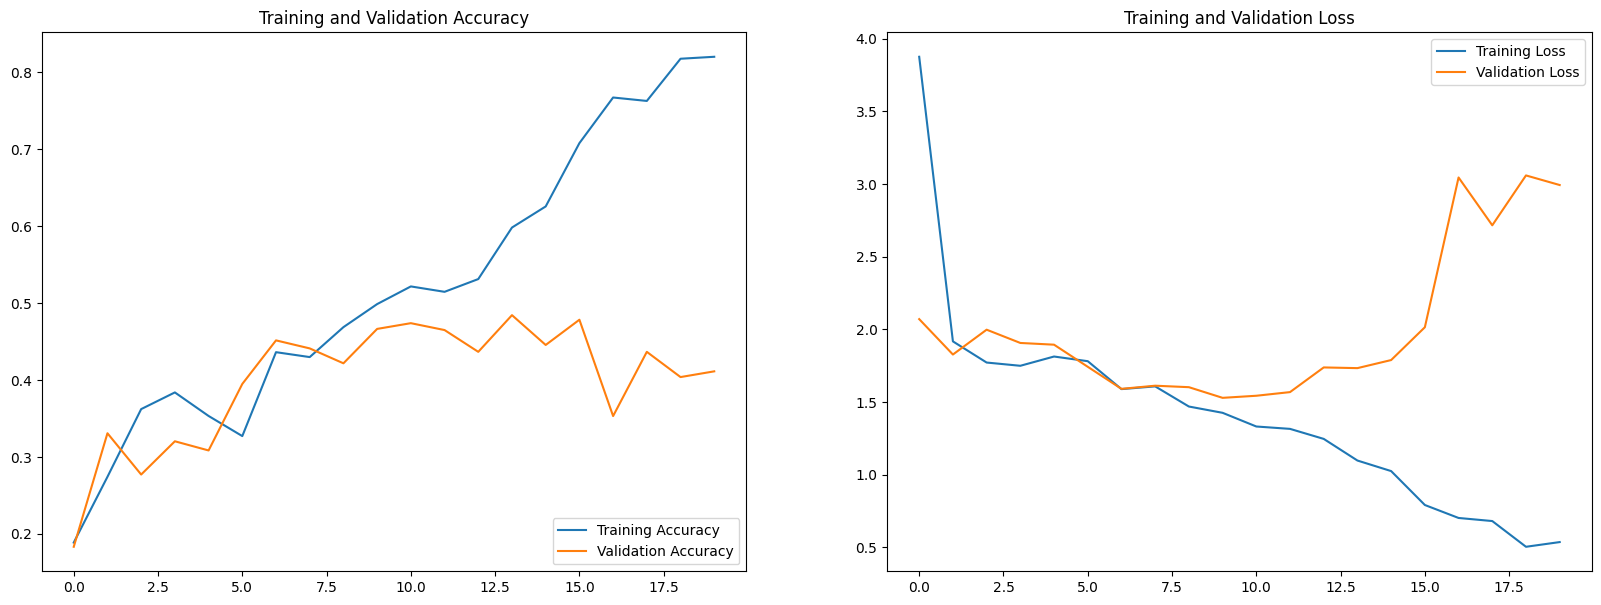

In [51]:
plot_history(history)

In [88]:
###  Basic model shows overfitting of data for training set

In [52]:
base_model.evaluate(test_images, test_labels, batch_size=32)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.2434 - f1_score: 0.1763 - loss: 5.9125 - precision: 0.2690 - recall: 0.2217


[5.91455078125,
 0.2542372941970825,
 <tf.Tensor: shape=(9,), dtype=float32, numpy=
 array([0.        , 0.3589743 , 0.09523807, 0.12499996, 0.39344263,
        0.3243243 , 0.        , 0.09999997, 0.39999995], dtype=float32)>,
 0.27551019191741943,
 0.2288135588169098]

In [53]:
y_pred = base_model.predict(test_images)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step


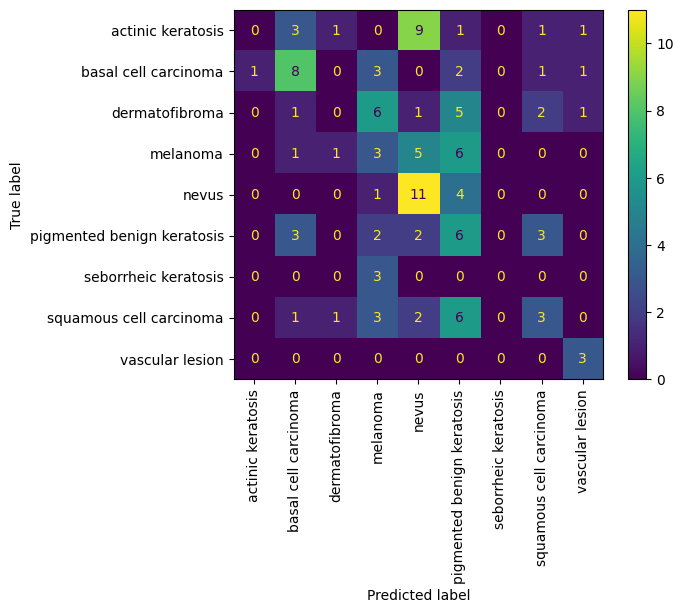

In [ ]:
display_matrix(y_pred, test_labels)

(-0.5, 179.5, 179.5, -0.5)

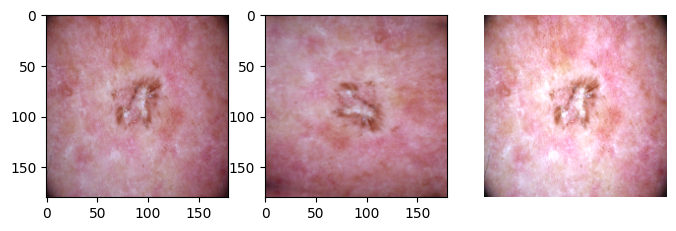

In [ ]:
## Data Flip and Rotate
data_flip_rotate = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])

## Data Bright and Contrast
data_light_contrast = tf.keras.Sequential([
  layers.RandomBrightness(factor=0.2),
  layers.RandomContrast(factor=0.4),
])

imgs, lbls = next(iter(train_df))
plt.figure(figsize=(8, 7))
ax = plt.subplot(2, 3, 1)
plt.imshow(imgs[0].numpy()/255)
augmented_image = data_flip_rotate(imgs[0])
ax = plt.subplot(2, 3, 2)
plt.imshow(augmented_image.numpy()/255)
augmented_image = data_light_contrast(imgs[0])
ax = plt.subplot(2, 3, 3)
plt.imshow(augmented_image.numpy()/255)
plt.axis("off")

In [60]:

def aug_model():
  model = Sequential()
  model.add(keras.layers.Input(shape=(img_height, img_width, 3), batch_size=batch_size)),

  data_rescaling,

  model.add(keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), data_format="channels_last", activation=None)),
  model.add(keras.layers.Activation('relu')),
  model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), data_format="channels_last", activation=None)),
  model.add(keras.layers.Activation('relu')),
  model.add(MaxPooling2D(pool_size=(2,2))),
  model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', data_format="channels_last", activation=None)),
  model.add(keras.layers.Activation('relu')),
  model.add(keras.layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', data_format="channels_last", activation=None)),
  model.add(keras.layers.Activation('relu')),
  model.add(MaxPooling2D(pool_size=(2,2))),
  model.add(keras.layers.Dropout(rate=0.3)),
  model.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', data_format="channels_last", activation=None)),
  model.add(keras.layers.Activation('relu')),
  model.add(keras.layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), data_format="channels_last", activation=None)),
  model.add(keras.layers.Activation('relu')),
  model.add(MaxPooling2D(pool_size=(2,2))),
  model.add(keras.layers.Dropout(rate=0.3)),
  model.add(keras.layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', data_format="channels_last", activation=None)),
  model.add(keras.layers.Activation('relu')),

  model.add(keras.layers.Flatten()),
  model.add(keras.layers.Dense(256, activation='relu')),
  model.add(keras.layers.Dropout(rate=0.3)),
  model.add(keras.layers.Dense(256, activation='relu')),
  model.add(keras.layers.Dense(len(class_names), activation='softmax'))

  ## Compile the model
  model.compile(optimizer='Adam',
                loss = "categorical_crossentropy",
                metrics=["accuracy",
                        "f1_score",
                        "precision",
                        "recall"])

  return model

In [61]:
aug_model = aug_model()
aug_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)              │ (32, 178, 178, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (32, 178, 178, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (32, 176, 176, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (32, 176, 176, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (32, 88, 88, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (32, 88, 88, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (32, 88, 88, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (32, 88, 88, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (32, 88, 88, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (32, 44, 44, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 44, 44, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (32, 44, 44, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (32, 44, 44, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (32, 42, 42, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_52 (Activation)      │ (32, 42, 42, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (32, 21, 21, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 21, 21, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (32, 21, 21, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_53 (Activation)      │ (32, 21, 21, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (32, 112896)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (32, 256)              │    28,901,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (32, 256)              │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (32, 9)                │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,542,729 (112.70 MB)

 Trainable params: 29,542,729 (112.70 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
history = aug_model.fit(train_images, train_labels, epochs=20, validation_data=(val_images, val_labels))

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.1863 - f1_score: 0.0921 - loss: 35.0893 - precision: 0.1992 - recall: 0.0570 - val_accuracy: 0.2131 - val_f1_score: 0.0392 - val_loss: 2.0551 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.1713 - f1_score: 0.0691 - loss: 2.1302 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1818 - val_f1_score: 0.0342 - val_loss: 2.0516 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.2052 - f1_score: 0.0708 - loss: 2.0437 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2385 - val_f1_score: 0.0732 - val_loss: 2.0278 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.1967 - f1_score: 0.0778 - loss: 2.0146 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1967 - val_f1_score: 0.0506 - val_loss: 2.0

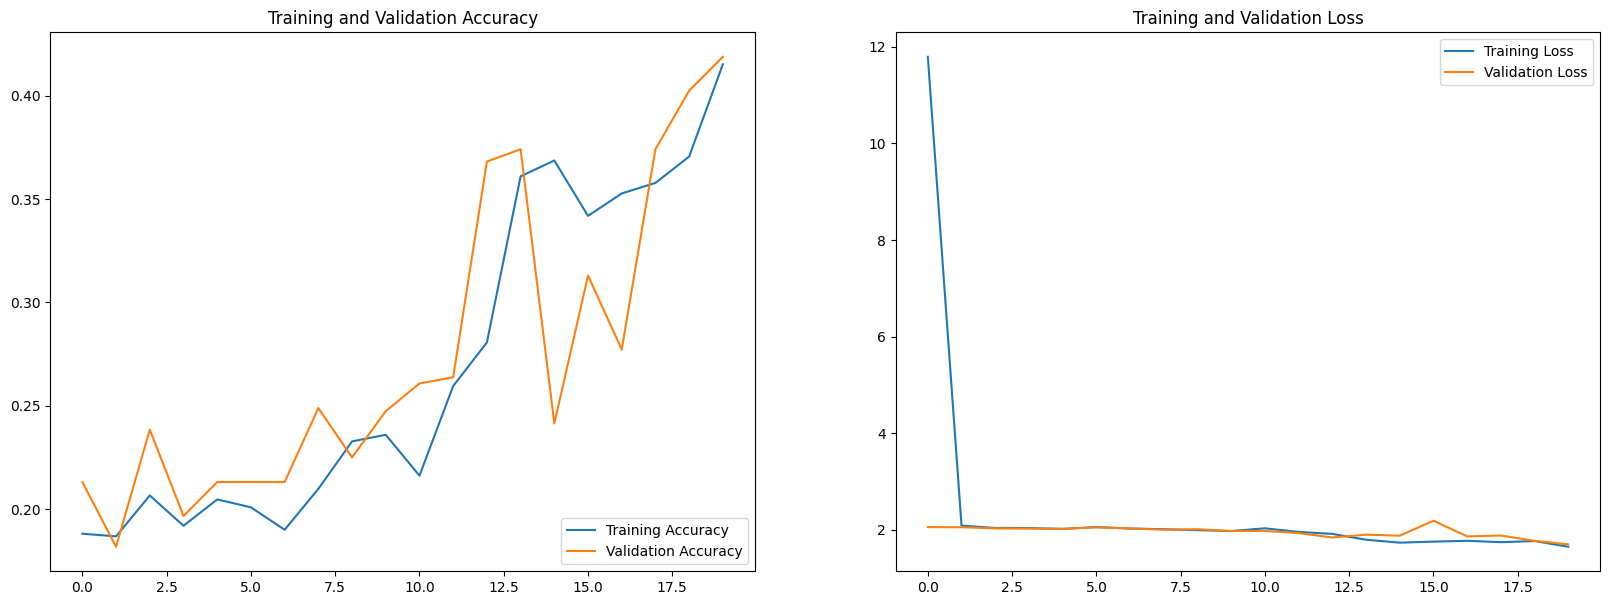

In [57]:
plot_history(history)

In [87]:
### Adding dropouts has addressed the issue of overfitting on training data

In [58]:
aug_model.evaluate(test_images, test_labels, batch_size=32)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.2139 - f1_score: 0.1412 - loss: 2.1275 - precision: 0.2712 - recall: 0.0675


[2.1413469314575195,
 0.2118644118309021,
 <tf.Tensor: shape=(9,), dtype=float32, numpy=
 array([0.        , 0.40909085, 0.        , 0.2222222 , 0.08333328,
        0.27397257, 0.        , 0.        , 0.2857142 ], dtype=float32)>,
 0.2800000011920929,
 0.05932203307747841]

In [59]:
y_pred = aug_model.predict(test_images)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000018F87D5A520> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


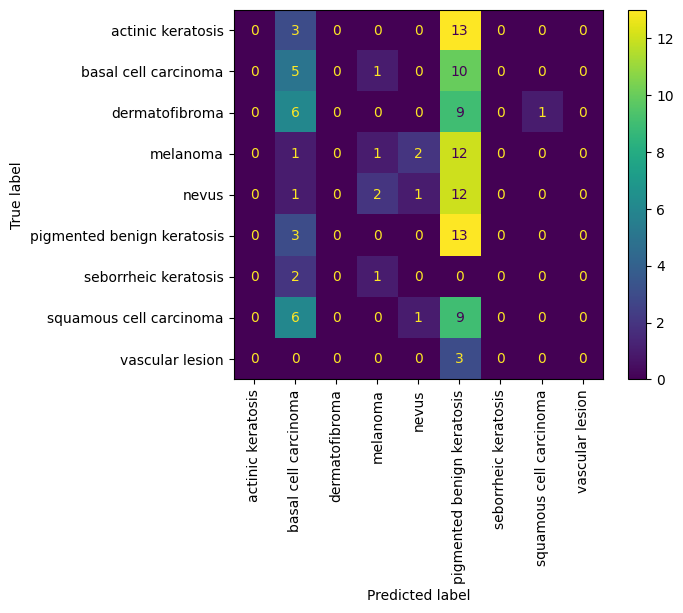

In [ ]:
display_matrix(y_pred, test_labels)

In [ ]:
### Using Augmentator library for Training Dataset

In [ ]:
train_dataset = create_dataset(data_dir_train)

In [ ]:
def aug_images():
  for i in class_names:
    dir_path = data_dir_train / i
    img_pipe = Augmentor.Pipeline(dir_path)
    img_pipe.rotate(probability=0.5, max_left_rotation=20, max_right_rotation=20)
    img_pipe.random_brightness(probability = 0.5, min_factor=0.0, max_factor=0.3)
    img_pipe.flip_random(probability=0.5)
    img_pipe.sample(500)

In [ ]:
aug_images()

Initialised with 116 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B3A201807F0>: 100%|██████████| 500/500 [00:21<00:00, 23.25 Samples/s]


Initialised with 401 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B3A201807C0>: 100%|██████████| 500/500 [00:22<00:00, 21.76 Samples/s]


Initialised with 119 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B3A201D77F0>: 100%|██████████| 500/500 [00:23<00:00, 21.67 Samples/s]


Initialised with 439 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B3A20172350>: 100%|██████████| 500/500 [01:26<00:00,  5.76 Samples/s]


Initialised with 387 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7B3A284A2CB0>: 100%|██████████| 500/500 [01:26<00:00,  5.80 Samples/s]


Initialised with 463 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B3A201D7DC0>: 100%|██████████| 500/500 [00:23<00:00, 21.22 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B3A2834AF20>: 100%|██████████| 500/500 [00:44<00:00, 11.15 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B3A20172E90>: 100%|██████████| 500/500 [00:24<00:00, 20.01 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B3A20185FF0>: 100%|██████████| 500/500 [00:22<00:00, 22.50 Samples/s]


In [ ]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
aug_train_dataset = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
aug_train_df = pd.concat([train_dataset, aug_train_dataset], ignore_index=True)

In [ ]:
aug_train_df.head()

,Path,Label
0,/content/drive/MyDrive/CNN_assignment/Train/ac...,actinic keratosis
1,/content/drive/MyDrive/CNN_assignment/Train/ac...,actinic keratosis
2,/content/drive/MyDrive/CNN_assignment/Train/ac...,actinic keratosis
3,/content/drive/MyDrive/CNN_assignment/Train/ac...,actinic keratosis
4,/content/drive/MyDrive/CNN_assignment/Train/ac...,actinic keratosis


In [ ]:
## Generate Model with Augmentated Data

In [ ]:
for class_dir in os.listdir(data_dir_train):
    class_path = os.path.join(data_dir_train, class_dir)

    # Check if it's a directory
    out_dir_path = data_dir_train / class_dir / "output"
    if os.path.isdir(class_path):
        output_dir = os.path.join(class_path, out_dir_path)

        # If there's an 'output' directory, move its images to the parent class directory
        if os.path.isdir(out_dir_path):
            for image_name in os.listdir(out_dir_path):
                image_path = os.path.join(out_dir_path, image_name)
                if os.path.isfile(image_path):
                    shutil.move(image_path, class_path)  # Move the image to the class directory
            # Optionally, remove the empty output directory
            os.rmdir(out_dir_path)

In [63]:
aug_train_df, aug_val_df = image_dataset_from_directory(data_dir_train, image_size=(img_height, img_width), shuffle=True, seed = 123, subset="both", labels='inferred', label_mode ='int', validation_split=0.3, batch_size=batch_size, color_mode = 'rgb')

Found 6822 files belonging to 9 classes.
Using 4776 files for training.
Using 2046 files for validation.


In [64]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
aug_train_df = aug_train_df.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
aug_val_df = aug_val_df.cache().prefetch(buffer_size=AUTOTUNE)

In [65]:
aug_train = aug_train_df.map(lambda images, labels: (images, tf.one_hot(labels, len(class_names))))
aug_val = aug_val_df.map(lambda images, labels: (images, tf.one_hot(labels, len(class_names))))

In [66]:
train_images, train_labels = split_data(aug_train)

In [67]:
val_images, val_labels = split_data(aug_val)

In [68]:
history = aug_model.fit(train_images, train_labels, epochs=30, validation_data=(val_images, val_labels))

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.1323 - f1_score: 0.0742 - loss: 4.2252 - precision: 0.1106 - recall: 0.0094 - val_accuracy: 0.1403 - val_f1_score: 0.0273 - val_loss: 2.1788 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.1320 - f1_score: 0.0460 - loss: 2.1778 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1432 - val_f1_score: 0.0278 - val_loss: 2.1790 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.1237 - f1_score: 0.0524 - loss: 2.1801 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1432 - val_f1_score: 0.0278 - val_loss: 2.1784 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.1336 - f1_score: 0.0420 - loss: 2.1782 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1432 - val_f1_score: 0.0278 - va

In [69]:
core_test_df = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), shuffle=True, seed = 123, subset=None, labels='inferred', label_mode = 'int', validation_split=None, batch_size=batch_size, color_mode = 'rgb')
core_test_df = core_test_df.cache().prefetch(buffer_size=AUTOTUNE)
test_df = core_test_df.map(lambda images, labels: (images, tf.one_hot(labels, len(class_names))))

Found 120 files belonging to 9 classes.


In [70]:
test_images, test_labels = split_data(test_df)

In [71]:
aug_model.evaluate(test_images, test_labels, batch_size=32)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.1200 - f1_score: 0.0237 - loss: 2.1779 - precision: 0.0000e+00 - recall: 0.0000e+00


[2.1739630699157715,
 0.13333334028720856,
 <tf.Tensor: shape=(9,), dtype=float32, numpy=
 array([0.       , 0.       , 0.       , 0.       , 0.       , 0.2352941,
        0.       , 0.       , 0.       ], dtype=float32)>,
 0.0,
 0.0]

In [72]:
test_images, test_labels = split_data(test_df)

In [73]:
y_pred = aug_model.predict(test_images)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


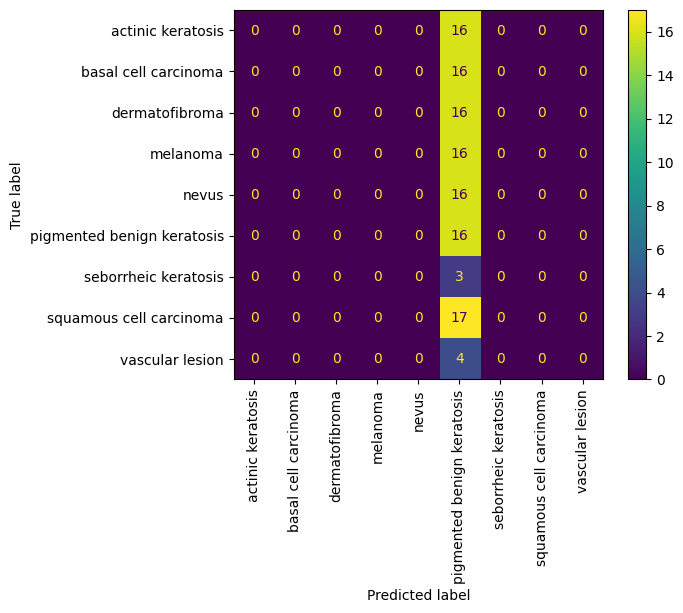

In [74]:
display_matrix(y_pred, test_labels)